In [9]:
from __future__ import print_function, division, absolute_import, unicode_literals
from pleiades.wipplsystems import BRB
from pleiades.helpers import *
from pleiades.grids import RectGrid
from pleiades.core import ZSymmCoilSet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import os
from pleiades.math import get_gpsi
from pleiades.eq_solve import compute_equilibrium
from pleiades.io import write_eqdsk


In [10]:
# build grid
RZgrid = RectGrid((0,1,121),(-.5,.5,121))
R,Z = RZgrid.R, RZgrid.Z

# build brb vessel and specify current values, patch masks, etc
trex_cur = 2000
mir_cur = 80000*1.2
#mir_cur = 160000
brb = BRB()
#brb.trex.Ncoil.z0 = .4
#brb.trex.Scoil.z0 = -.4
brb.trex.currents = [trex_cur,trex_cur]
brb.ltrx.currents = [0,0]
brb.ltrx.patch_mask = [1,1]
brb.vessel_mags.currents = [0,0,0]
mirror_set = ZSymmCoilSet(r0=0.15,z0=0.55,nr=11,nz=5,dr=.01,dz=.01)
brb.add_component(mirror_set,"mirrors")
brb.mirrors.currents = [mir_cur,mir_cur]

# set the brb grid (does all greens functions calculations right here)
brb.grid = RZgrid

In [11]:
# force psi_lim through rlim1,zlim1 and rlim2,zlim2
rlim1,zlim1 = 0.08,0.5
rlim2,zlim2 = 0.6,0.0
r1idx,z1idx = np.abs(R[0,:]-rlim1).argmin(), np.abs(Z[:,0]-zlim1).argmin()
r2idx,z2idx = np.abs(R[0,:]-rlim2).argmin(), np.abs(Z[:,0]-zlim2).argmin()
gm1,gm2 = np.sum(brb.mirrors.gpsi,axis=-1).reshape(R.shape)[z1idx,r1idx], np.sum(brb.mirrors.gpsi,axis=-1).reshape(R.shape)[z2idx,r2idx]
gc1,gc2 = np.sum(brb.trex.gpsi,axis=-1).reshape(R.shape)[z1idx,r1idx], np.sum(brb.trex.gpsi,axis=-1).reshape(R.shape)[z2idx,r2idx]
gp1,gp2 = 0, 0
iplas = 0
new_trex_cur = -((gm1-gm2)*brb.mirrors.currents[0] + (gp1-gp2)*iplas)/(gc1 - gc2)
print(new_trex_cur)
brb.trex.currents = [new_trex_cur,new_trex_cur]


2738.976415737309


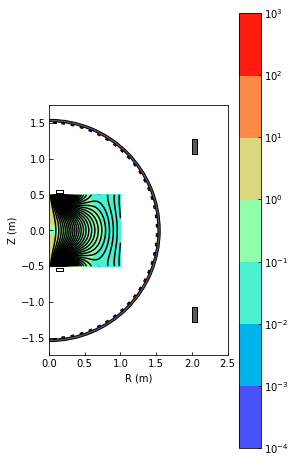

In [12]:
# get desired field quantities from brb object and view coilset
B = np.sqrt(brb.BR**2+brb.BZ**2)
BR = brb.BR
BZ = brb.BZ
psi = brb.psi
psi_lim = locs_to_vals(R,Z,psi,[(rlim1,zlim1)])[0]
psi_space = np.linspace(0,psi_lim,11)

# Plotting Section
fig,ax = plt.subplots(figsize=(4,8))
cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator())
ax.contour(R,Z,psi,51,colors="k")
plt.colorbar(cf)
ax.set_xlim(0,2.5)
ax.set_ylim(-1.75,1.75)
ax.set_xlabel("R (m)")
ax.set_ylabel("Z (m)")
ax.set_aspect(1)
ax.add_collection(brb.patch_coll)
plt.show()

pressure  33940.5952421905
computing gpsi blocks...
creating reflected block matrix
building huge matrix...
returning...
0
1
1
3.32169255679273
2
0.053463212447237805
3
0.010296290132771889
4
0.00014147685847639473
5
4.065849333043902e-05
6
6.081653581923291e-07
7
1.6586988651122703e-07
8
3.105708435004731e-09
9
6.798066735433269e-10
10
1.640475088722286e-11


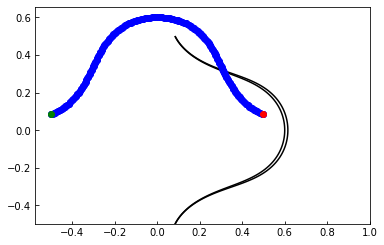

In [13]:
# setup pressure profile and compute P0 for a given desired initial beta
a = .6
alpha = 2.0
beta0 = .1
B0 = locs_to_vals(R,Z,B,[(0,0)])[0]
P0 = beta0*B0**2/(2*4*np.pi*1E-7)
print("pressure ", P0)
# build pressure function of cylindrical radius
Pfunc = lambda x: P0*(1-(x/a)**2)**alpha if x < a else 0
# get greens function for plasma currents
gplas = get_gpsi(R,Z)
# compute equilibrium
psieq,plas_currents,pfit = compute_equilibrium(R,Z,Pfunc,psi,gplas,maxiter=400,plotit=False)
write_eqdsk(R,Z,psi,plas_currents,"mfnpeqdsk1.txt","MFNP_Mirror Equilib")
P = pfit(psi.flatten()).reshape(psi.shape)
jphi = plas_currents/((R[0,1]-R[0,0])*(Z[1,0]-Z[0,0]))

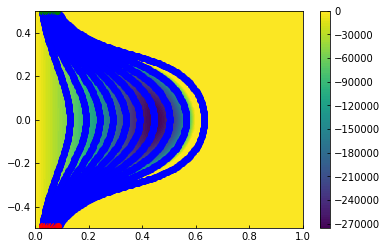

In [14]:
fig,ax = plt.subplots()
cf = ax.contourf(R,Z,jphi,101)
cs = ax.contour(R,Z,psieq,psi_space,colors="k")
for clev in psi_space[1:]:
    flpts = get_fieldlines(cs,clev,start_coord=(0.05,.5),end_coord=(0.05,-0.5),clockwise=True)
    ax.plot(flpts[:,0],flpts[:,1],"bo")
    ax.plot(flpts[0,0],flpts[0,1],"go")
    ax.plot(flpts[-1,0],flpts[-1,1],"ro")

plt.colorbar(cf)
plt.show()

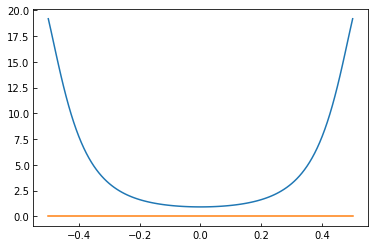

In [15]:
#### Plotting 
# plot slice of Bz as function of Z at R=0
ridx = np.abs(R[0,:]).argmin()
plt.plot(Z[:,ridx],BZ[:,ridx])
plt.plot(Z[:,ridx],BR[:,ridx])
plt.show()

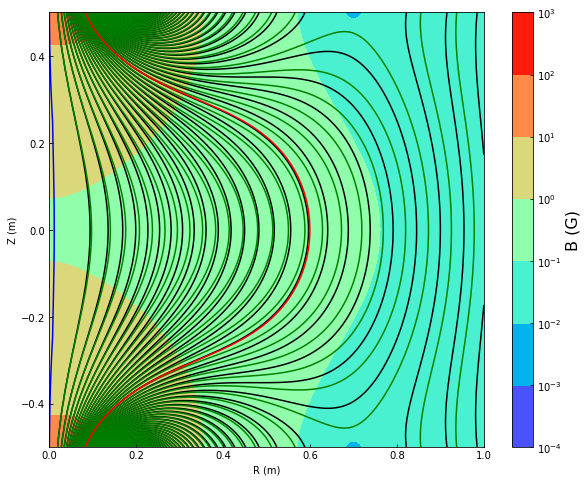

In [16]:
# plot BRB with patches and stuff
fig,ax = plt.subplots(figsize=(10,8))
cf = ax.contourf(R,Z,B,101,cmap="rainbow",locator=ticker.LogLocator(),zorder=0)
cs = ax.contour(R,Z,psi,51,colors='k',lw=2,zorder=1)
cs1 = ax.contour(R,Z,psieq,51,colors='g',lw=2,zorder=1)
cs = ax.contour(R,Z,psi,(psi_lim,),colors='r',lw=2,zorder=1)
cs = ax.contour(R,Z,psi,(7629.87E-8,),colors='b',lw=2,zorder=1)
cbar = fig.colorbar(cf)
cbar.set_label("B (G)",fontsize=16)
ax.set_xlim(0,1.0)
ax.set_ylabel("Z (m)")
ax.set_xlabel("R (m)")
ax.set_ylim(-.5,.5)
ax.set_aspect('equal')
patches = brb.patches
ax.add_collection(PatchCollection(patches,match_original=True))
plt.show()